# Generating figures for paper

In [1]:
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('grid')
# plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# errbar_kwargs = dict(marker='.', markersize=3, capsize=3, elinewidth=1, lw=1)
# plot_kwargs = dict(marker='.', markersize=3, lw=1)
# errband_kwargs = dict(alpha=0.25)
errbar_kwargs = dict(estimator='mean', errorbar=('ci', 95), errwidth=1.25, capsize=0.05,)

save_dir = '../neurips/figs/experiments'

In [2]:
cmap = plt.cm.tab20

In [3]:
our_model_name = 'Dual-Attn Transformer'# 'Orthrus' # 'AbstractTransformer' # Orthrus

## Relational Games

In [76]:
relgames_data = pd.read_csv('figure_data/relgames/relgames_data.csv')

def process_groupname(group_name):
    task, model_name = group_name.split('__')
    return model_name


L, total_n_heads = 2, 2
filter_ = (relgames_data['n_layers'] == L) & ((relgames_data['n_heads_rca'] + relgames_data['n_heads_sa'] == total_n_heads) | (relgames_data['n_heads'] == total_n_heads)) & (relgames_data['train_size'] <= 25_000)
figure_data = relgames_data[filter_]

figure_data['Model'] = figure_data['group'].apply(process_groupname)

figure_data.rename(columns={'train_size': 'Training Set Size', 'test/acc_in_distribution': 'Generalization Accuracy', 'task': 'Task'}, inplace=True)

In [77]:
def parse_rel_symmetry(group_name):
    if 'sym_rel=True' in group_name:
        return True
    elif 'sym_rel=False' in group_name:
        return False
    else:
        return None

figure_data['Symmetric RA'] = figure_data['group'].apply(parse_rel_symmetry)

In [78]:
models = [
    'sa=2; d=128; L=2',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    ]
model_name_map = {
    'sa=2; d=128; L=2': 'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
    'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)",
    'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)",
    }
models = [model_name_map[m] for m in models]

tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']
task_name_map = {
    '1task_between': r'$\texttt{between}$', '1task_match_patt': r'$\texttt{match pattern}$',
    'same': r'$\texttt{same}$', 'occurs': r'$\texttt{occurs}$', 'xoccurs': r'$\texttt{xoccurs}$'}
tasks = [task_name_map[t] for t in tasks]

figure_data['Model'] = pd.Categorical(figure_data['Model'].map(model_name_map), models, ordered=True)
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(task_name_map), tasks, ordered=True)


# bar plot figure
color_map_ = {
    f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
    f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
    f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
    'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)': cmap(6), # red
    "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)": cmap(8),
    "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)": cmap(0),
    # 'Transformer+': cmap(4),
    }


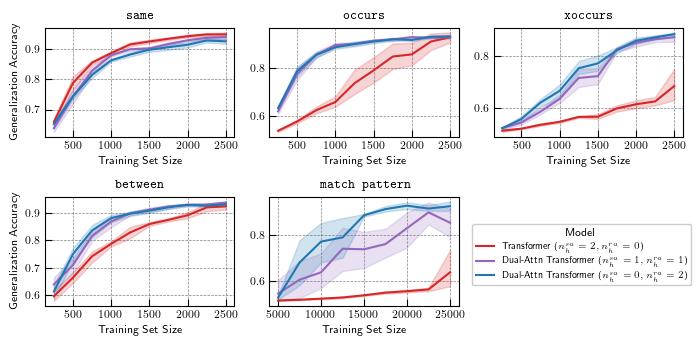

In [87]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Symmetric RA']!=False]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.175), fontsize='medium', title='Model')
fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.675, 0.175), fontsize='small', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves.pdf')

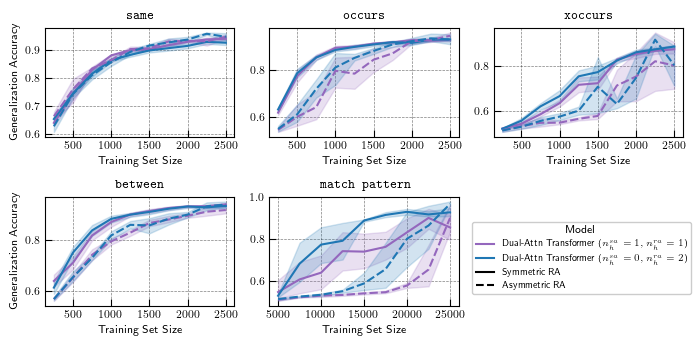

In [88]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]
    # config filter
    ax_data = ax_data[ax_data['rca_type']=='disentangled_v2']
    ax_data = ax_data[~ax_data['Symmetric RA'].isna()]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', style='Symmetric RA', style_order=[True, False], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
legend_labels = [*models[1:3], 'Symmetric RA', 'Asymmetric RA']

# fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.720, 0.15), fontsize='small', title='Model')
fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.675, 0.15), fontsize='small', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_symmetry_ablation.pdf')

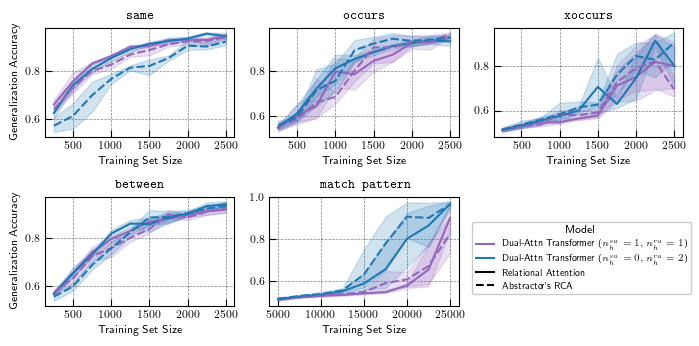

In [90]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Symmetric RA']==False]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', style='rca_type', style_order=['disentangled_v2', 'standard'], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
# legend_labels = ['$n_h^{{sa}}=1, n_h^{{ra}}=1$', '$n_h^{{sa}}=0, n_h^{{ra}}=2$', 'Disentangled Relational Attention', "Abstractor's RCA"]
legend_labels = [f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)', f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)', 'Relational Attention', "Abstractor's RCA"]

# fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.69, 0.15), fontsize='medium', title='Model')
fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.675, 0.15), fontsize='small', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_rcatype_ablation.pdf')

## Math

In [102]:
figure_data = pd.read_csv('figure_data/math/run_history_all.csv')

In [103]:
# bar plot figure
color_map_ = {
    f'{our_model_name} (config 1)': cmap(8), # purple
    f'{our_model_name} (config 2)': cmap(0), # blue
    # 'Transformer': cmap(7), # lighter red
    'Transformer': cmap(6), # red
    # 'Transformer+': cmap(6), # red # NOTE: removed Transformer+ for now
    # 'Transformer+': cmap(4),
    }


models = {
    'e_sa=8; e_rca=0; d_sa=8; d_rca=0; d_cross=8; d=128; rca_type=NA, symbol_type=NA; el=2; dl=2': 'Transformer',
    # 'ee=8; ea=0; de=8; da=0; dc=8; el=2; dl=2': 'Transformer',
    # 'e_sa=8; e_rca=0; d_sa=8; d_rca=0; d_cross=8; d=144; rca_type=NA, symbol_type=NA; el=2; dl=2': 'Transformer+', # NOTE: removed Transformer+ for now
    'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': f'{our_model_name} (config 1)',
    'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': f'{our_model_name} (config 2)',
    # 'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v1; OGRCA)',
    # 'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v2; OGRCA)',
    }

In [104]:
figure_data.rename(columns={
    'epoch': 'Epoch', 'interpolate_teacher_forcing_acc': 'Accuracy (Interpolation)', 'extrapolate_teacher_forcing_acc': 'Accuracy (Extrapolation)', 
    'train_teacher_forcing_acc': 'Accuracy (Training)', 'task': 'Task', 'group': 'Model'}, inplace=True)

def format_task(task):
    string = task.replace('__', r'\_\_')
    string = r"$\texttt{" + string + r"}$"
    return string
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(format_task))
figure_data = figure_data[figure_data['Model'].isin(models.keys())]
figure_data['Model'] = pd.Categorical(figure_data['Model'].map(models), models.values(), ordered=True)

In [105]:
# TODO: need to run more trials for some, etc.
figure_data.groupby(['Model', 'Task'])['Accuracy (Training)'].aggregate('count')

Model                             Task                                    
Transformer                       $\texttt{algebra\_\_linear_1d}$             400
                                  $\texttt{algebra\_\_sequence_next_term}$    400
                                  $\texttt{calculus\_\_differentiate}$        400
                                  $\texttt{polynomials\_\_add}$               400
                                  $\texttt{polynomials\_\_expand}$            400
Dual-Attn Transformer (config 1)  $\texttt{algebra\_\_linear_1d}$             964
                                  $\texttt{algebra\_\_sequence_next_term}$    952
                                  $\texttt{calculus\_\_differentiate}$        940
                                  $\texttt{polynomials\_\_add}$               976
                                  $\texttt{polynomials\_\_expand}$            988
Dual-Attn Transformer (config 2)  $\texttt{algebra\_\_linear_1d}$             955
                       

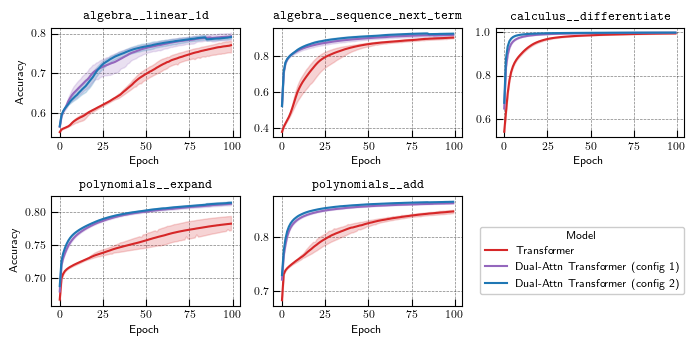

In [109]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.69, 0.15), fontsize='medium', title='Model')
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_trainacc.pdf')

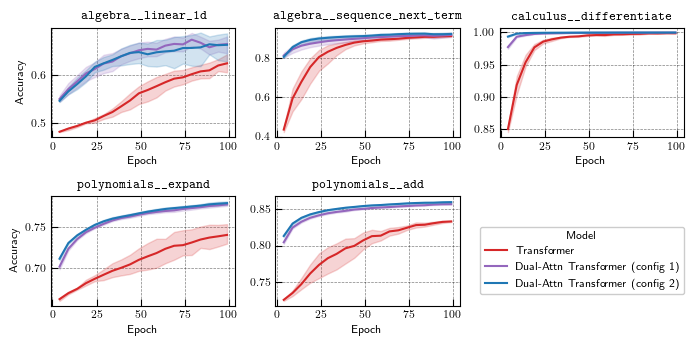

In [110]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.69, 0.15), fontsize='medium', title='Model')
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_interpolation.pdf')

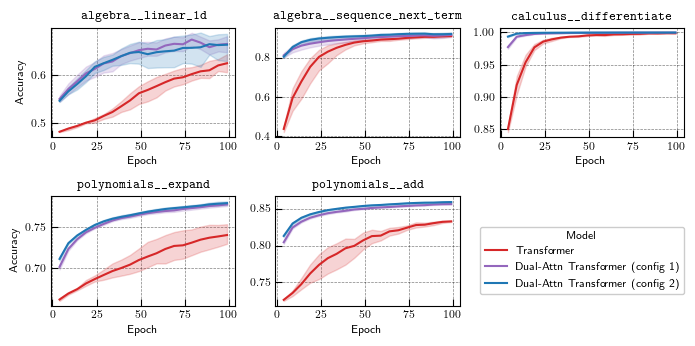

In [111]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Extrapolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.69, 0.15), fontsize='medium', title='Model')
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_extrapolation.pdf')

## Language Modeling: Fineweb

In [210]:
figure_data = pd.read_csv('figure_data/fineweb/run_histories.csv')
figure_data.head()

C:\Users\awnya\AppData\Local\Temp\ipykernel_10912\188304530.py:1: DtypeWarning: Columns (498,500,501) have mixed types. Specify dtype option on import or set low_memory=False.
  figure_data = pd.read_csv('figure_data/fineweb/run_histories.csv')


,grad_norms/blocks.0.dual_attn.self_attention.wv.weight,grad_norms/blocks.4.ff_block.linear2.bias,grad_norms/blocks.8.ff_block.linear2.bias,layer_grad_norms/block_5,grad_norms/blocks.5.dual_attn.relational_attention.wq_rel.weight,layer_grad_norms/block_22,grad_norms/blocks.22.dual_attn.relational_attention.wq_attn.weight,grad_norms/blocks.9.dual_attn.self_attention.wk.weight,grad_norms/blocks.15.dual_attn.self_attention.wo.weight,grad_norms/blocks.10.norm2.bias,...,grad_norms/symbol_retrievers.22.q_proj.weight,grad_norms/symbol_retrievers.4.template_features,grad_norms/symbol_retrievers.20.q_proj.weight,grad_norms/symbol_retrievers.18.template_features,grad_norms/symbol_retriever.q_proj.weight,grad_norms/symbol_retriever.q_proj.bias,grad_norms/symbol_retriever.template_features,grad_norms/symbol_retriever.rel_pos_enc.rel_pos_embeddings,norm,grad_norms/symbol_retriever.symbol_library
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
name_map = {
    'T-sa32-1.3B_2024_07_11_19_05_56': 'Transformer - 1.31B', # TODO: check exact param count (is it 1.31B or sthn)
    'T-sa32-1.3B_2024_07_11_19_05_56_resumed_2024_07_26_18_41_46': 'Transformer - 1.31B',
    'DAT-sa16-ra16-nr64-ns512-sh16-nkvh8-1.27B_2024_07_24_09_41_58': f'{our_model_name} - 1.27B',
    'DAT-sa16-ra16-nr64-ns2048-sh8-1.37B_2024_07_22_18_31_43': f'{our_model_name} - 1.37B',

    'T-350M_2024_07_09_17_25_58': 'Transformer - 353M', # TODO check exact param count
    'DAT-sa8-ra8-ns1024-sh8-nkvh4-343M_2024_07_19_13_50_14': f'{our_model_name} - 343M',
    'DAT-sa8-ra8-ns1024-sh8-nkvh4-343M_2024_07_19_13_50_14_resumed_2024_07_26_18_49_04': f'{our_model_name} - 343M',
    'DAT-ra8sa8nr32-ns1024sh8-368M_2024_07_15_18_38_39': f'{our_model_name} - 368M', # TODO: decide precisely which models want here
}

In [212]:
# bar plot figure
color_map_ = {
    'Transformer - 1.31B': cmap(6), # red
    f'{our_model_name} - 1.27B': cmap(0), # blue
    f'{our_model_name} - 1.37B': cmap(8), # purple

    'Transformer - 353M': cmap(6), # red
    f'{our_model_name} - 343M': cmap(0), # blue
    f'{our_model_name} - 368M': cmap(8), # purple
    }

# models = color_map_.keys()

In [213]:
figure_data = figure_data[figure_data.name.isin(name_map.keys())]
figure_data = figure_data[['name', 'loss/val', 'tokens']].dropna()

figure_data = figure_data.rename(columns={
    # 'symbol_type': 'Symbol Type', 'symmetric_rels': 'Symmetric RA', 
    'loss/val': 'Validation Loss', 'tokens': 'Tokens'})


figure_data['Model'] = pd.Categorical(figure_data['name'].map(name_map), list(set(name_map.values())), ordered=True)

figure_data['Perplexity'] = figure_data['Validation Loss'].apply(np.exp)

# figure_data = figure_data[['Model', 'Tokens', 'Perplexity']].dropna()

In [225]:
figure_data[figure_data.Tokens==figure_data.Tokens.max()]

,name,Validation Loss,Tokens,Model,Perplexity
55,DAT-sa8-ra8-ns1024-sh8-nkvh4-343M_2024_07_19_1...,2.788589,9.961472e+09,Dual-Attn Transformer - 343M,16.258071
964,T-sa32-1.3B_2024_07_11_19_05_56_resumed_2024_0...,2.612265,9.961472e+09,Transformer - 1.31B,13.629889
3861,DAT-sa16-ra16-nr64-ns512-sh16-nkvh8-1.27B_2024...,2.598214,9.961472e+09,Dual-Attn Transformer - 1.27B,13.439715
7677,DAT-sa16-ra16-nr64-ns2048-sh8-1.37B_2024_07_22...,2.597204,9.961472e+09,Dual-Attn Transformer - 1.37B,13.426149
30418,DAT-ra8sa8nr32-ns1024sh8-368M_2024_07_15_18_38_39,2.770631,9.961472e+09,Dual-Attn Transformer - 368M,15.968704
49390,T-350M_2024_07_09_17_25_58,2.829942,9.961472e+09,Transformer - 353M,16.944482


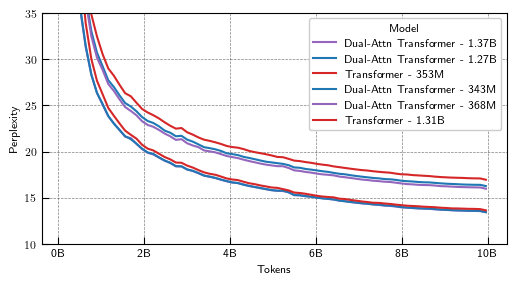

In [214]:
# fig1_models = ['Transformer - 35XM', f'{our_model_name} - 343M', f'{our_model_name} - 368M']
# fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
# fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(figure_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
ax.set_ylim([10, 35]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);

C:\Users\awnya\AppData\Local\Temp\ipykernel_10912\791518408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)


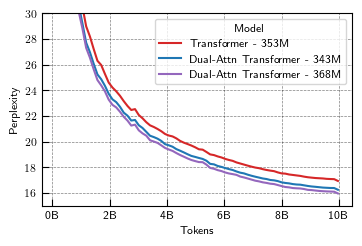

In [224]:
fig1_models = ['Transformer - 353M', f'{our_model_name} - 343M', f'{our_model_name} - 368M']
fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(fig1_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax.set_ylim([15, 30]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
fig.savefig(f'{save_dir}/fineweb/350M_scale_lm.pdf', bbox_inches='tight')

C:\Users\awnya\AppData\Local\Temp\ipykernel_10912\3104186031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)


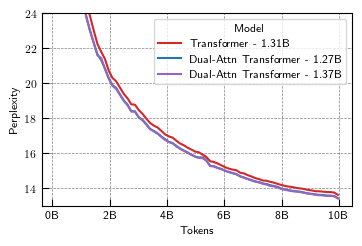

In [221]:
fig2_models = ['Transformer - 1.31B', f'{our_model_name} - 1.27B', f'{our_model_name} - 1.37B']
fig2_data = figure_data[figure_data.Model.isin(fig2_models)]
fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(fig2_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax.set_ylim([13, 24]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
fig.savefig(f'{save_dir}/fineweb/1_3B_scale_lm.pdf', bbox_inches='tight')

## Language Modeling: Tiny Stories

In [ ]:
figure_data = pd.read_csv('figure_data/tiny_stories/run_histories.csv')
figure_data.head()

,val/perplexity,mfu,tokens,Generated Samples,lr,val/loss,train/loss,_timestamp,_step,train/perplexity,...,n_layers,wandb_log,weight_decay,vocab_source,out_dir,pos_enc_type,beta1,sym_attn_n_symbols,group,name
0,39238.144531,-100.000000,0.000000e+00,NaN,0.001,10.577385,10.578004,1.716068e+09,0,39261.359375,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
1,5.612392,3.820743,2.621440e+08,NaN,0.001,1.724343,1.727050,1.716069e+09,2000,5.626907,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
2,4.960096,3.820697,5.242880e+08,NaN,0.001,1.600834,1.604139,1.716071e+09,4000,4.975849,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
3,4.704290,3.820555,7.864320e+08,NaN,0.001,1.547904,1.550540,1.716072e+09,6000,4.716177,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
4,4.540239,3.820479,1.048576e+09,NaN,0.001,1.512442,1.515324,1.716074e+09,8000,4.552852,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...


In [ ]:
# bar plot figure
color_map_ = {
    'Transformer ($n_h^{sa}=8, n_h^{ra}=0$)': cmap(6), # red
    f'{our_model_name} ($n_h^{{sa}}=6, n_h^{{ra}}=2$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=4, n_h^{{ra}}=4$)': cmap(0), # blue
    # 'Transformer+': cmap(4),
    }

models = color_map_.keys()

In [ ]:
def get_model_name(row):
    if row.rca == 0:
        return f'Transformer ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)'
    else:
        # return f"AbstractTransformer [{row['Symbol Type']}, symm={row['Symmetric RA']}] ($n_h^{{sa}} = {row.sa}, n_h^{{ra}}={row.rca}$)"
        return f"{our_model_name} ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)"

In [ ]:
figure_data = figure_data.rename(columns={
    'symbol_type': 'Symbol Type', 'symmetric_rels': 'Symmetric RA', 
    'val/loss': 'Validation Loss', 'val/perplexity': 'Validation Perplexity', 'tokens': 'Tokens'})

figure_data.loc[figure_data['rca']==0, 'Symbol Type'] = 'NA'
figure_data.loc[figure_data['rca']==0, 'Symmetric RA'] = 'NA'

figure_data['Model'] = pd.Categorical(figure_data.apply(get_model_name, axis=1), models, ordered=True)
sym_map = {'sym_attn': 'Symbolic Attention', 'pos_relative': 'Position-Relative Symbols'}
figure_data['Symbol Type'] = pd.Categorical(figure_data['Symbol Type'].map(sym_map), sym_map.values(), ordered=True)

In [ ]:
def filter_data(figure_data, d_models=None, layers=None, filter_first_step=False, filter_transformer=False, symbol_types=None, symmetry=None, rca_types=None):
    filter_ = ~figure_data.index.isna()
    if d_models is not None:
        filter_ = filter_ & (figure_data['d_model'].isin(d_models))
    if layers is not None:
        filter_ = filter_ & (figure_data['n_layers'].isin(layers))
    if filter_transformer:
        filter_ = filter_ & (figure_data['rca'] > 0)
    if filter_first_step:
        filter_ = filter_ & (figure_data['_step'] > 0)
    if symbol_types is not None:
        symbol_types = [sym_map[s] for s in symbol_types]
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symbol Type'].isin(symbol_types))
    if symmetry is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symmetric RA'].isin(symmetry))
    if rca_types is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | (figure_data['rca_type'].isin(rca_types)))
    filtered_data = figure_data.copy()[filter_]

    if filter_transformer:
        filtered_data['Model'] = filtered_data['Model'].cat.remove_unused_categories()

    return filtered_data

### All Plots & Ablations

============================================ d=64; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


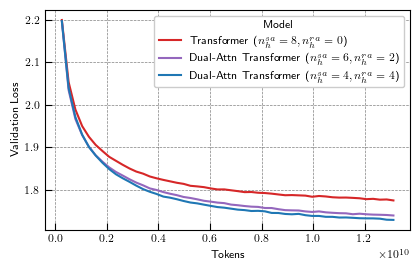

Symbolic Attention & Symmetric DisRA


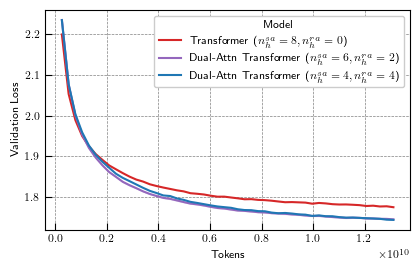

Ablation of Symmetry (Symbolic Attention)


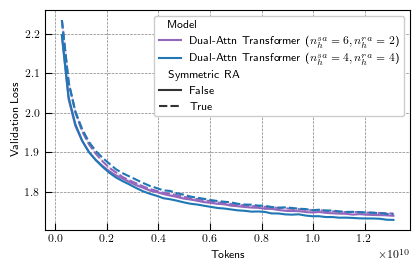

Ablation of Symmetry (Position-Relative Symbols)


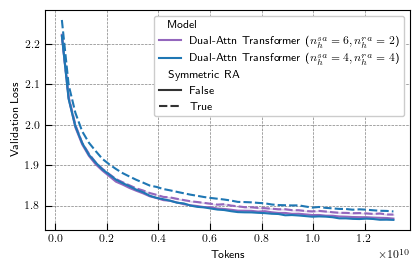

Ablation of Symbol Type (Symmetric DisRA)


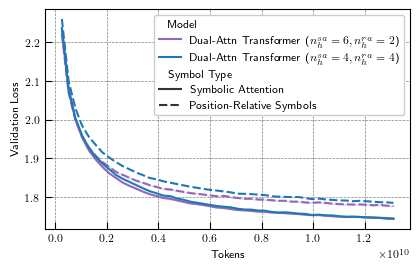

Ablation of Symbol Type (Asymmetric DisRA)


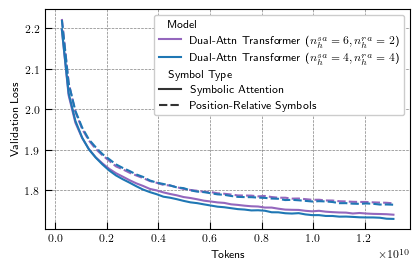

============================================ d=64; L=5 =============================================
Symbolic Attention & Asymmetric DisRA


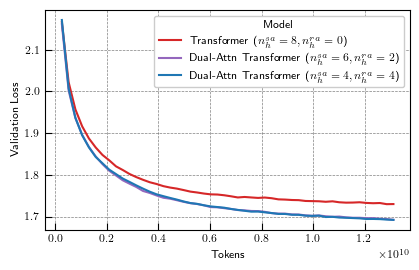

Symbolic Attention & Symmetric DisRA


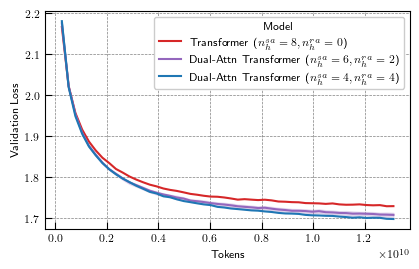

Ablation of Symmetry (Symbolic Attention)


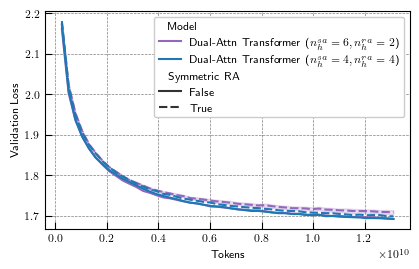

Ablation of Symmetry (Position-Relative Symbols)


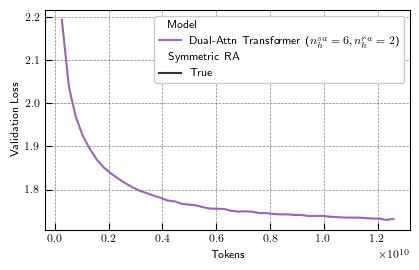

Ablation of Symbol Type (Symmetric DisRA)


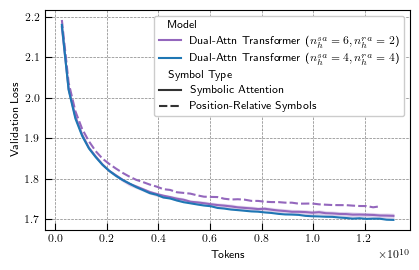

Ablation of Symbol Type (Asymmetric DisRA)


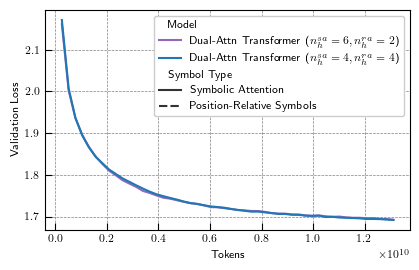

============================================ d=64; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


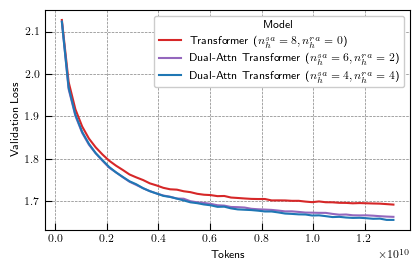

Symbolic Attention & Symmetric DisRA


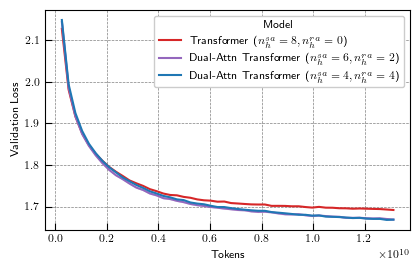

Ablation of Symmetry (Symbolic Attention)


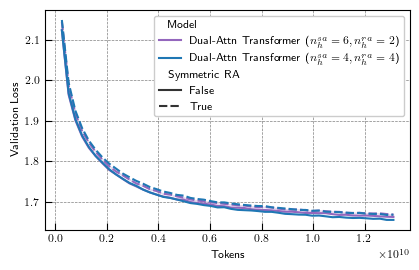

Ablation of Symmetry (Position-Relative Symbols)


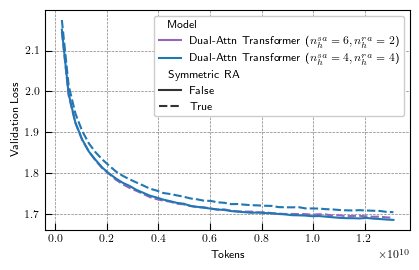

Ablation of Symbol Type (Symmetric DisRA)


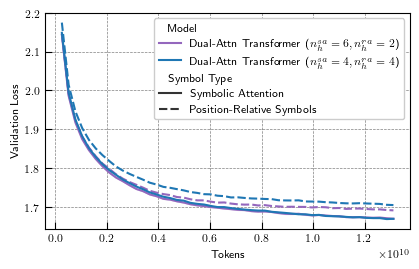

Ablation of Symbol Type (Asymmetric DisRA)


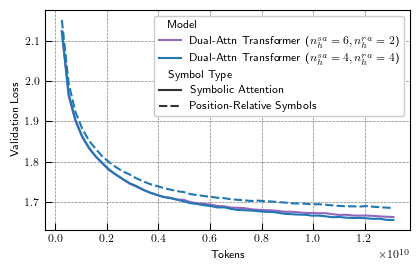

============================================ d=128; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


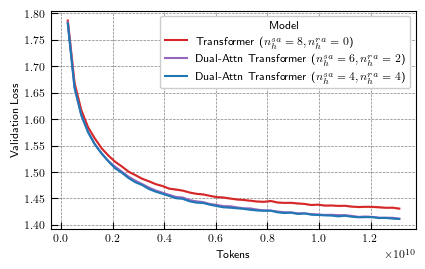

Symbolic Attention & Symmetric DisRA


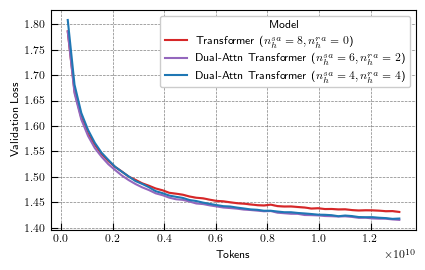

Ablation of Symmetry (Symbolic Attention)


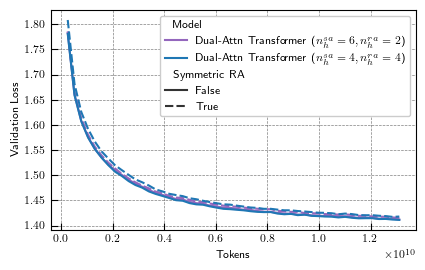

Ablation of Symmetry (Position-Relative Symbols)


C:\Users\awnya\AppData\Local\Temp\ipykernel_10020\2777058707.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);


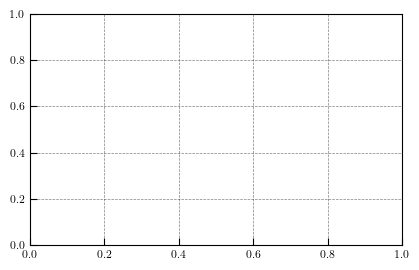

Ablation of Symbol Type (Symmetric DisRA)


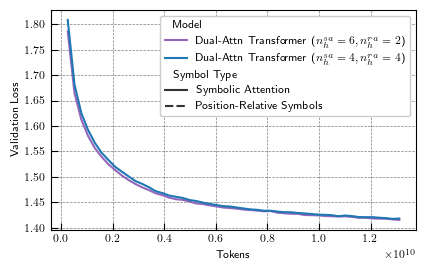

Ablation of Symbol Type (Asymmetric DisRA)


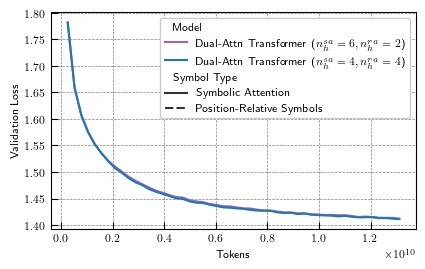

============================================ d=128; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


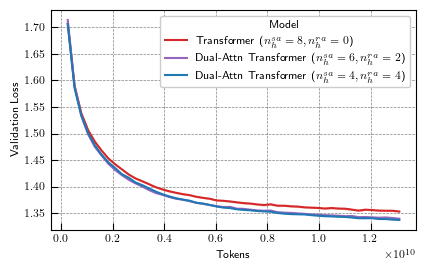

Symbolic Attention & Symmetric DisRA


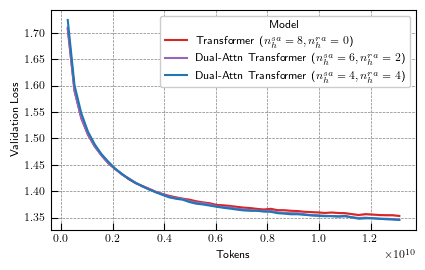

Ablation of Symmetry (Symbolic Attention)


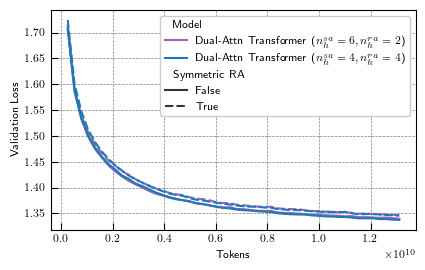

Ablation of Symmetry (Position-Relative Symbols)


C:\Users\awnya\AppData\Local\Temp\ipykernel_10020\2777058707.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);


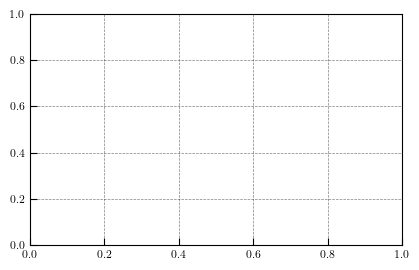

Ablation of Symbol Type (Symmetric DisRA)


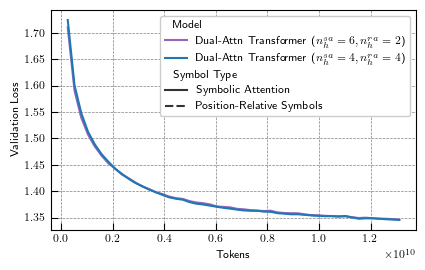

Ablation of Symbol Type (Asymmetric DisRA)


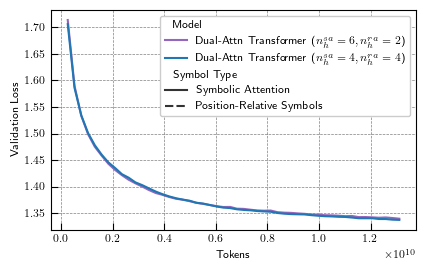

In [9]:
figsize=(4,2.5)
dLs = [(64, 4), (64, 5), (64, 6), (128, 4), (128, 6)]
for d, L in dLs:
    print('='*44 + f' d={d}; L={L} ' + '='*45)
    print('='*100)

    # symbolic attention and asymmetric RA
    print('Symbolic Attention & Asymmetric DisRA')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_asymra.pdf')
    plt.show()

    # symbolic attention and symmetric RA
    print('Symbolic Attention & Symmetric DisRA')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(True,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_symra.pdf')
    plt.show()

    # ablation of symmetry; symbolic attention
    print('Ablation of Symmetry (Symbolic Attention)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn',), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symmetry_symmattn.pdf')
    plt.show()

    # ablation of symmetry; position-relative symbols
    print('Ablation of Symmetry (Position-Relative Symbols)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('pos_relative',), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symmetry_posrelsym.pdf')
    plt.show()

    # ablation of symbol type; symmetric rel
    print('Ablation of Symbol Type (Symmetric DisRA)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(True, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_symra.pdf')
    plt.show()

    # ablation of symbol type; asymmetric rel
    print('Ablation of Symbol Type (Asymmetric DisRA)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(False, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_asymra.pdf')
    plt.show()

    print('='*100)

Symbolic Attention & Asymmetric DisRA


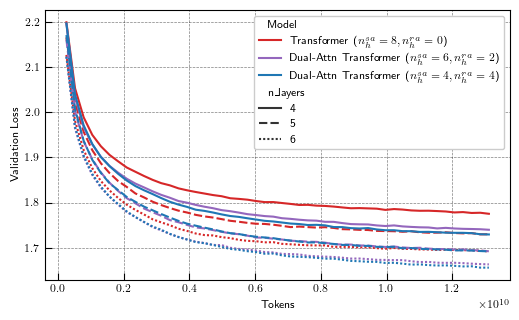

In [10]:
# symbolic attention and asymmetric RA
print('Symbolic Attention & Asymmetric DisRA')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[64], layers=[4, 5, 6], filter_first_step=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='n_layers', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d64L4L5L6_symattn_asymra.pdf')
plt.show()

Symbolic Attention & Asymmetric DisRA


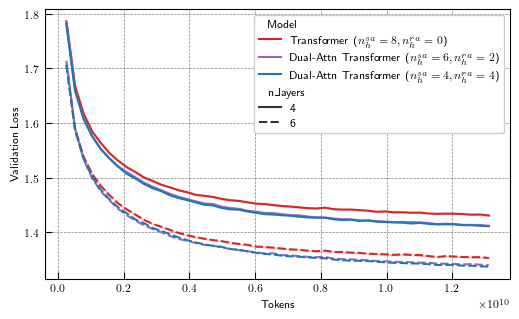

In [11]:
# symbolic attention and asymmetric RA
print('Symbolic Attention & Asymmetric DisRA')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[128], layers=[4,  6], filter_first_step=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='n_layers', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d128L4L6_symattn_asymra.pdf')
plt.show()

# TODO: need missing run with d=128,L=6, sym_attn, asym_ra, n_h^{sa}=4, n_h^{ra}=4

RA Type Ablation


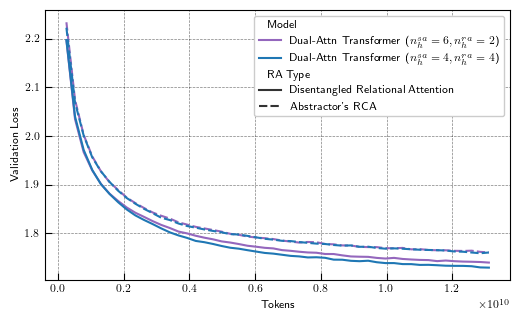

In [12]:
# RCA TYPE ABLATION
print('RA Type Ablation')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[64], layers=[4], filter_first_step=True, filter_transformer=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2', 'standard'))
figure_data_.rename(columns={'rca_type': 'RA Type'}, inplace=True)
figure_data_['Model'] = pd.Categorical(figure_data_['Model'], list(models)[1:], ordered=True) # remove transformer
figure_data_['RA Type'] = pd.Categorical(
    figure_data_['RA Type'].map(
        {'disentangled_v2': 'Disentangled  Relational Attention', 'standard': "Abstractor's RCA"}),
        ['Disentangled  Relational Attention', "Abstractor's RCA"], ordered=True)
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='RA Type', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d64L4_ra_type_ablation_symattn_asymra.pdf')
plt.show()

### Table Summary

In [13]:
figure_data['Symbol Type'] = figure_data['Symbol Type'].astype(str).fillna('NA')
figure_data['Symmetric RA'] = figure_data['Symmetric RA'].astype(str).fillna('NA')
figure_data['Symbol Type'] = figure_data['Symbol Type'].replace('nan', 'NA')

In [14]:
metric_cols = ['Validation Loss', 'Validation Perplexity']
group_cols = ['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA']

summary = filter_data(figure_data, rca_types=('disentangled_v2',)).groupby(group_cols)[metric_cols].min().reset_index().dropna(subset=metric_cols)

# filter out certain entries
summary = summary[summary.d_model <= 128]

summary.set_index(['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA'], inplace=True)
summary[metric_cols]= summary[metric_cols].round(3)
summary

Validation Loss  \
d_model n_layers sa rca Symbol Type               Symmetric RA                    
64      4        4  4   Position-Relative Symbols False                   1.764   
                                                  True                    1.785   
                        Symbolic Attention        False                   1.729   
                                                  True                    1.744   
                 6  2   Position-Relative Symbols False                   1.768   
                                                  True                    1.777   
                        Symbolic Attention        False                   1.740   
                                                  True                    1.745   
                 8  0   NA                        NA                      1.775   
        5        4  4   Symbolic Attention        False                   1.692   
                                                  True                    1.698   
                 6  2   Position-Relative Symbols True                    1.730   
                        Symbolic Attention        False                   1.692   
                                                  True                    1.704   
                 8  0   NA                        NA                      1.730   
        6        4  4   Position-Relative Symbols False                   1.685   
                                                  True                    1.704   
                        Symbolic Attention        False                   1.656   
                                                  True                    1.668   
                 6  2   Position-Relative Symbols True                    1.691   
                        Symbolic Attention        False                   1.663   
                                                  True                    1.669   
                 8  0   NA                        NA                      1.692   
128     4        4  4   Symbolic Attention        False                   1.411   
                                                  True                    1.417   
                 6  2   Symbolic Attention        False                   1.412   
                                                  True                    1.415   
                 8  0   NA                        NA                      1.431   
        6        4  4   Symbolic Attention        False                   1.337   
                                                  True                    1.346   
                 6  2   Symbolic Attention        False                   1.340   
                                                  True                    1.346   
                 8  0   NA                        NA                      1.353   

                                                                Validation Perplexity  
d_model n_layers sa rca Symbol Type               Symmetric RA                         
64      4        4  4   Position-Relative Symbols False                         5.840  
                                                  True                          5.963  
                        Symbolic Attention        False                         5.639  
                                                  True                          5.722  
                 6  2   Position-Relative Symbols False                         5.859  
                                                  True                          5.914  
                        Symbolic Attention        False                         5.697  
                                                  True                          5.727  
                 8  0   NA                        NA                            5.903  
        5        4  4   Symbolic Attention        False                         5.431  
                                                  True                          5.467  
              

In [15]:
# write string to file
# with open(f'{save_dir}/tiny_stories/tiny_stories_summary_table.tex', 'w') as f:
#     f.write(summary.to_latex())

## Vision

In [16]:
figure_data = pd.read_csv('figure_data/imagenet/run_histories.csv')
figure_data.dropna(subset=['train/acc_epoch', 'val/loss'], inplace=True, how='all') # drop step rows and keep epoch rows
figure_data.head()

In [17]:
model_name_map = {
    'sa=16; d=1024; L=24__2024_05_15_16_38_09': 'Transformer ($n_h^{sa}=16, n_h^{ra}=0$)',
    'sa=10; rca=6; d=1024; L=24; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_relative__2024_05_15_18_13_54': f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)'
    }

figure_data['Model'] = pd.Categorical(figure_data['name'].map(model_name_map), model_name_map.values(), ordered=True)

color_map_ = {
    'Transformer ($n_h^{sa}=16, n_h^{ra}=0$)': cmap(6), # red
    f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)': cmap(0), # blue
    }

In [18]:
df_ = figure_data[['epoch', 'train/acc_epoch', 'Model']].dropna().pivot(index='epoch', columns='Model', values='train/acc_epoch')
trainacc_diff = abs(df_.iloc[:,0] - df_.iloc[:,1])
print(f'train/acc mean difference: {trainacc_diff.mean():.2%}')
print(f'train/acc max difference: {trainacc_diff.max():.2%}')
print(f'train/acc end difference: {abs(max(df_.iloc[:,0]) - max(df_.iloc[:,1])):.2%}')
print()
df_ = figure_data[['epoch', 'val/acc', 'Model']].dropna().pivot(index='epoch', columns='Model', values='val/acc')
valacc_diff = abs(df_.iloc[:,0] - df_.iloc[:,1])
print(f'val/acc mean difference: {valacc_diff.mean():.2%}')
print(f'val/acc max difference: {valacc_diff.max():.2%}')
print(f'val/acc end difference: {abs(max(df_.iloc[:,0]) - max(df_.iloc[:,1])):.2%}')

train/acc mean difference: 5.01%
train/acc max difference: 10.08%
train/acc end difference: 2.89%

val/acc mean difference: 4.39%
val/acc max difference: 9.98%
val/acc end difference: 1.46%


In [23]:
figure_data.rename(columns={'train/acc_epoch': 'Training Accuracy', 'val/acc': 'Validation Accuracy',
    'val/loss': 'Validation Loss', 'train/loss_epoch': 'Training Loss', 'epoch': 'Epoch'}, inplace=True)

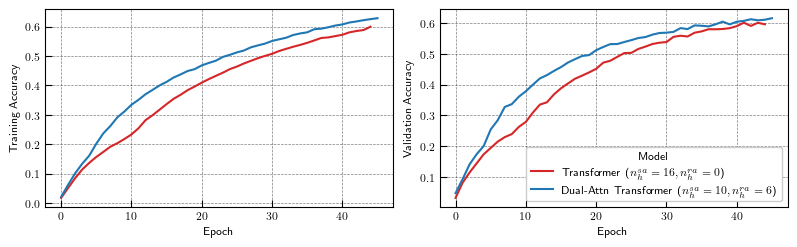

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 2.5), ncols=2, nrows=1)
sns.lineplot(figure_data, x='Epoch', y='Training Accuracy', hue='Model', palette=color_map_, ax=ax1, legend=False);
sns.lineplot(figure_data, x='Epoch', y='Validation Accuracy', hue='Model', palette=color_map_, ax=ax2);
# plt.subplots_adjust(wspace=0.2)
plt.tight_layout(pad=1)
fig.savefig(f'{save_dir}/imagenet/imagenet_acc_curves.pdf')

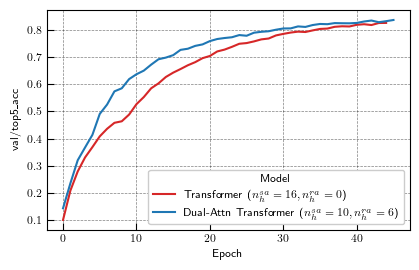

In [25]:
fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(figure_data, x='Epoch', y='val/top5_acc', hue='Model', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/imagenet/imagenet_top5acc_curves.pdf')

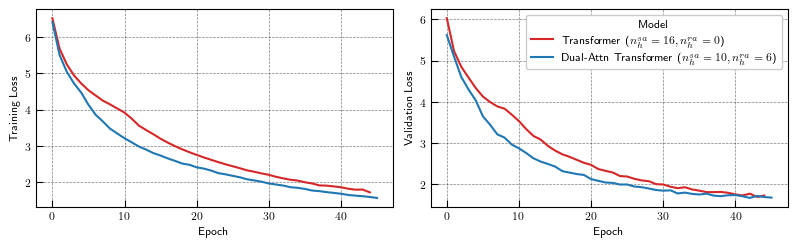

In [38]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 2.5), ncols=2, nrows=1)
sns.lineplot(figure_data, x='Epoch', y='Training Loss', hue='Model', palette=color_map_, ax=ax1, legend=False);
sns.lineplot(figure_data, x='Epoch', y='Validation Loss', hue='Model', palette=color_map_, ax=ax2);
plt.tight_layout(pad=1)
fig.savefig(f'{save_dir}/imagenet/imagenet_loss_curves.pdf')